In [ ]:
# 1️⃣  Hapus semua versi transformers lama yg nyangkut
!pip uninstall -y transformers -q

# 2️⃣  Install versi stabil minimal 4.42 (di‑uji cocok Torch 2.0 bawaan Colab)
!pip install -U "transformers==4.43.0" sentencepiece --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.6 MB/s eta 0:00:00


In [ ]:
import transformers, inspect
print(transformers.__version__)                     # 4.43.0
from transformers import TrainingArguments
print("evaluation_strategy" in inspect.signature(TrainingArguments).parameters)   # → True
from transformers.cache_utils import EncoderDecoderCache
print("✅ EncoderDecoderCache tersedia")



4.43.0
True
✅ EncoderDecoderCache tersedia


In [ ]:
import numpy as np
import pandas as pd
import torch
import shutil
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import importlib, os, sys, gc
from transformers import set_seed
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


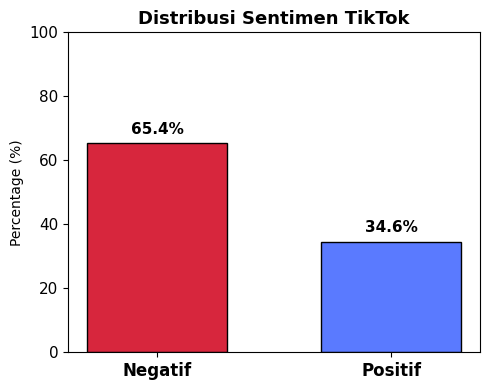

Jumlah data Negatif: 7054
Jumlah data Positif: 3735


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ganti path ke lokasi file lo
df = pd.read_csv("/content/drive/MyDrive/Kodingan TA/final_no_stop_removed_cleaned_sama_cleaned.csv")

# Map label: 0 = negative, 1 = positive
df['sentiment_str'] = df['sentiment_label'].map({0: 'Negatif', 1: 'Positif'})

# Hitung proporsi persentase
sentiment_counts = df['sentiment_str'].value_counts(normalize=True).reindex(['Negatif', 'Positif']).fillna(0) * 100
# Hitung jumlah absolut
sentiment_abs = df['sentiment_str'].value_counts().reindex(['Negatif', 'Positif']).fillna(0).astype(int)

colors = ['#d7263d', '#5a7aff']

plt.figure(figsize=(5, 4))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors, edgecolor='black', width=0.6)
plt.title('Distribusi Sentimen TikTok', fontsize=13, fontweight='bold')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)

for bar, value in zip(bars, sentiment_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('bar_sentiment_distribution.png', transparent=True)
plt.show()

# Print jumlah sentimen
print("Jumlah data Negatif:", sentiment_abs['Negatif'])
print("Jumlah data Positif:", sentiment_abs['Positif'])



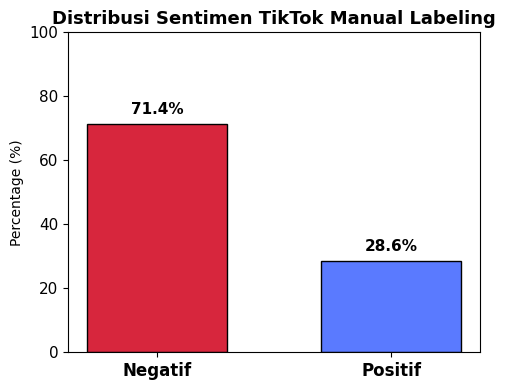

Jumlah data Negatif: 3000
Jumlah data Positif: 1200


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ganti path ke lokasi file lo
df = pd.read_csv("/content/drive/MyDrive/Kodingan TA/final dataset 4000ribu data.csv")

# Map label: 0 = negative, 1 = positive
df['sentiment_str'] = df['sentiment_label'].map({0: 'Negatif', 1: 'Positif'})

sentiment_counts = df['sentiment_str'].value_counts(normalize=True).reindex(['Negatif', 'Positif']).fillna(0) * 100

colors = ['#d7263d', '#5a7aff']

plt.figure(figsize=(5, 4))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors, edgecolor='black', width=0.6)
plt.title('Distribusi Sentimen TikTok Manual Labeling', fontsize=13, fontweight='bold')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)

for bar, value in zip(bars, sentiment_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('bar_sentiment_distribution.png', transparent=True)
plt.show()

# Print jumlah sentimen
sentiment_abs = df['sentiment_str'].value_counts().reindex(['Negatif', 'Positif']).fillna(0).astype(int)
print("Jumlah data Negatif:", sentiment_abs['Negatif'])
print("Jumlah data Positif:", sentiment_abs['Positif'])



## visualisasi epoch traning 10 ribu data

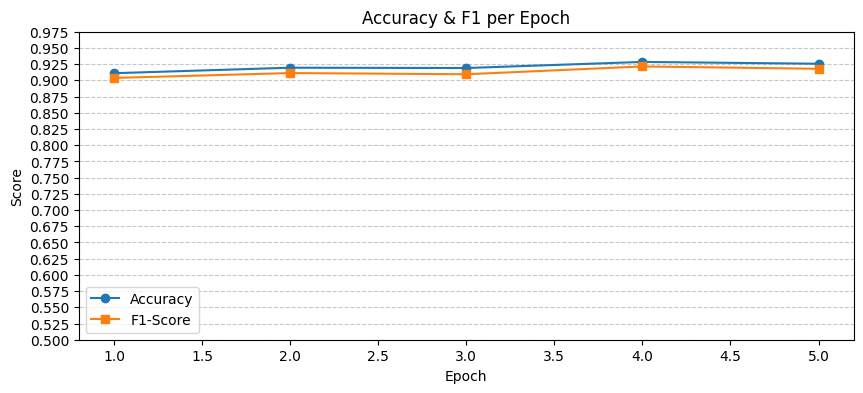

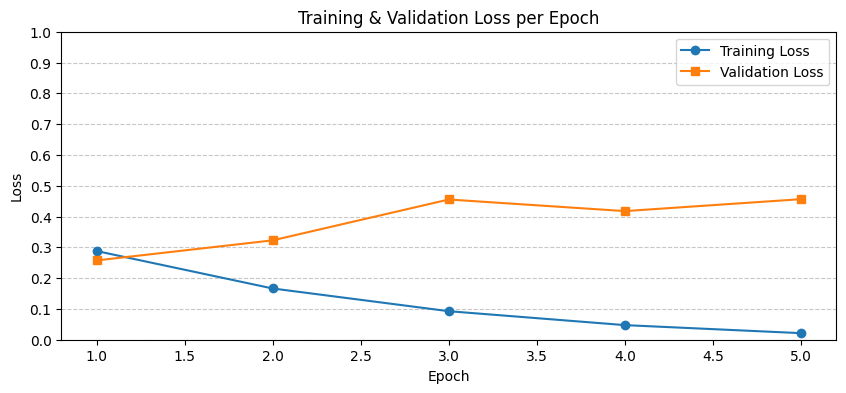

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# KODE INI UNTUK 10.000 DATA
# ==============================

# Data dari tabel gambar pertama
epoch = [1, 2, 3, 4, 5]
training_loss = [0.288, 0.1664, 0.0926, 0.0474, 0.0213]
validation_loss = [0.257424, 0.322631, 0.455277, 0.417603, 0.456354]
accuracy = [0.911017, 0.919492, 0.919021, 0.928437, 0.925612]
f1 = [0.903713, 0.911257, 0.909404, 0.921437, 0.917821]

# === Plot Accuracy & F1 (sumbu y: 0.5-0.975, sesuai revisi dosen) ===
plt.figure(figsize=(10,4))
plt.plot(epoch, accuracy, marker='o', label="Accuracy")
plt.plot(epoch, f1, marker='s', label="F1-Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy & F1 per Epoch")
plt.ylim(0.5, 0.975)
plt.yticks(np.arange(0.5, 1.0, 0.025))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# === Plot Loss (sumbu y: 0-1, sesuai revisi dosen) ===
plt.figure(figsize=(10,4))
plt.plot(epoch, training_loss, marker='o', label="Training Loss")
plt.plot(epoch, validation_loss, marker='s', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


## Visualisasi Epoch training 4000 data

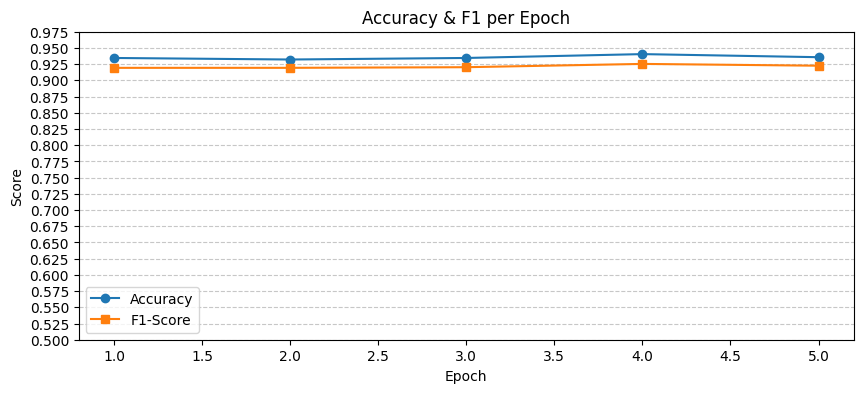

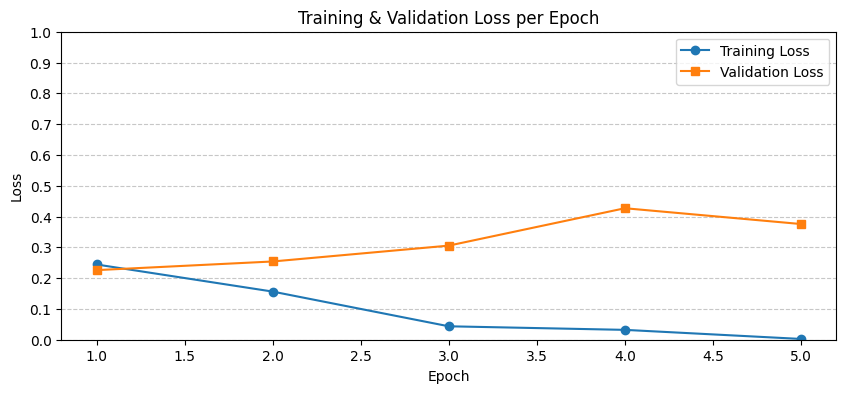

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# KODE INI UNTUK 4.000 DATA
# ==============================

epoch = [1, 2, 3, 4, 5]
training_loss = [0.2443, 0.1563, 0.0436, 0.0320, 0.0025]
validation_loss = [0.225951, 0.254031, 0.305537, 0.426920, 0.375587]
f1 = [0.919284, 0.919309, 0.920286, 0.925362, 0.922579]
accuracy = [0.934524, 0.932143, 0.934524, 0.940476, 0.935714]

# === Plot Accuracy & F1 (y: 0.5-0.975) ===
plt.figure(figsize=(10,4))
plt.plot(epoch, accuracy, marker='o', label="Accuracy")
plt.plot(epoch, f1, marker='s', label="F1-Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy & F1 per Epoch")
plt.ylim(0.5, 0.975)
plt.yticks(np.arange(0.5, 1.0, 0.025))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# === Plot Loss (y: 0-1) ===
plt.figure(figsize=(10,4))
plt.plot(epoch, training_loss, marker='o', label="Training Loss")
plt.plot(epoch, validation_loss, marker='s', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


## Tanpa Replies


===== FOLD 1 =====
Distribusi train: Counter({0: 5555, 1: 2940})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.288000,0.257424,0.911017,0.903713
2,0.166400,0.322631,0.919492,0.911257
3,0.092600,0.455277,0.919021,0.909404
4,0.047400,0.417603,0.928437,0.921437
5,0.021300,0.456354,0.925612,0.917821



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.94      0.94      1389
     Positif       0.89      0.91      0.90       735

    accuracy                           0.93      2124
   macro avg       0.92      0.92      0.92      2124
weighted avg       0.93      0.93      0.93      2124



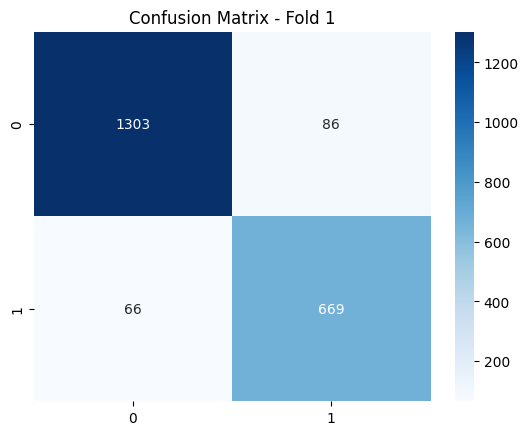

✅ Fold 1 TERBAIK sementara (F1 0.9214)

===== FOLD 2 =====
Distribusi train: Counter({0: 5555, 1: 2940})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.287600,0.203221,0.930791,0.924138
2,0.171200,0.199490,0.939266,0.933138
3,0.098700,0.292496,0.935028,0.928451
4,0.058400,0.326680,0.936441,0.929851



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.95      0.95      1389
     Positif       0.91      0.92      0.91       735

    accuracy                           0.94      2124
   macro avg       0.93      0.93      0.93      2124
weighted avg       0.94      0.94      0.94      2124



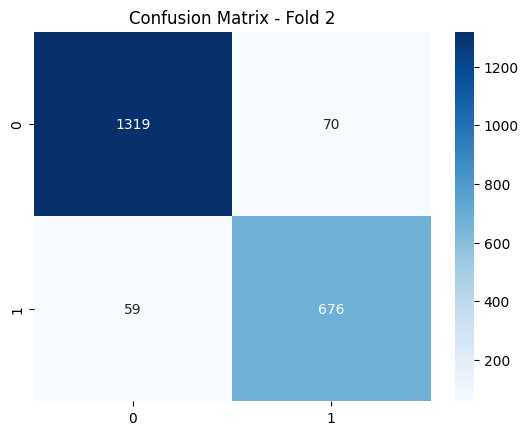

✅ Fold 2 TERBAIK sementara (F1 0.9331)

===== FOLD 3 =====
Distribusi train: Counter({0: 5555, 1: 2940})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.290300,0.234811,0.927966,0.920190
2,0.173900,0.289804,0.927495,0.919694
3,0.099700,0.335480,0.931262,0.924723
4,0.053600,0.368778,0.932674,0.925928
5,0.024900,0.426617,0.932674,0.925646



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.94      0.95      1389
     Positif       0.90      0.91      0.90       735

    accuracy                           0.93      2124
   macro avg       0.92      0.93      0.93      2124
weighted avg       0.93      0.93      0.93      2124



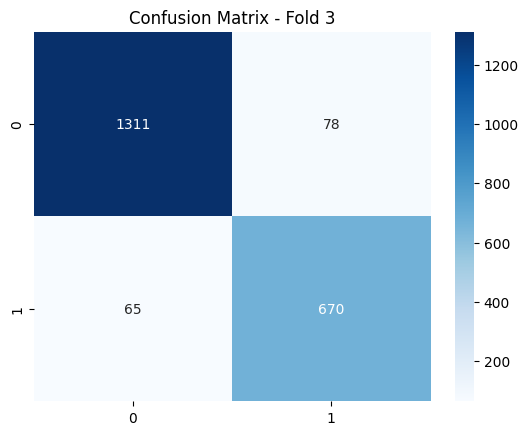

🗑️  Folder fold 3 dihapus

===== FOLD 4 =====
Distribusi train: Counter({0: 5555, 1: 2940})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.285700,0.313879,0.908192,0.895470
2,0.162600,0.294788,0.914783,0.904499
3,0.089500,0.445737,0.913371,0.904298
4,0.041100,0.488456,0.916667,0.907610
5,0.024400,0.507622,0.913371,0.905188



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.93      0.94      0.94      1389
     Positif       0.89      0.87      0.88       735

    accuracy                           0.92      2124
   macro avg       0.91      0.91      0.91      2124
weighted avg       0.92      0.92      0.92      2124



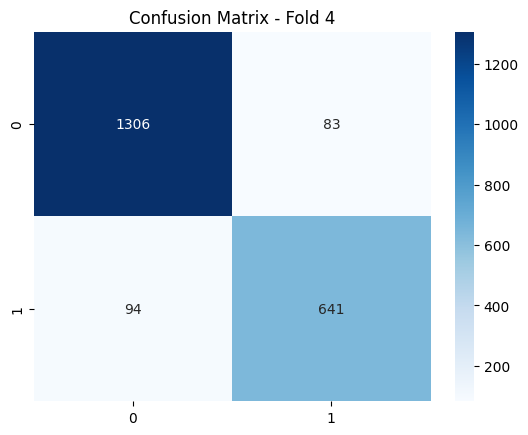

🗑️  Folder fold 4 dihapus

===== FOLD 5 =====
Distribusi train: Counter({0: 5556, 1: 2940})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.293200,0.279358,0.910504,0.897703
2,0.170700,0.308735,0.911446,0.904541
3,0.095500,0.415380,0.920867,0.910614
4,0.044600,0.443967,0.927461,0.920034
5,0.022700,0.472402,0.925577,0.917372



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.94      0.94      1388
     Positif       0.89      0.90      0.90       735

    accuracy                           0.93      2123
   macro avg       0.92      0.92      0.92      2123
weighted avg       0.93      0.93      0.93      2123



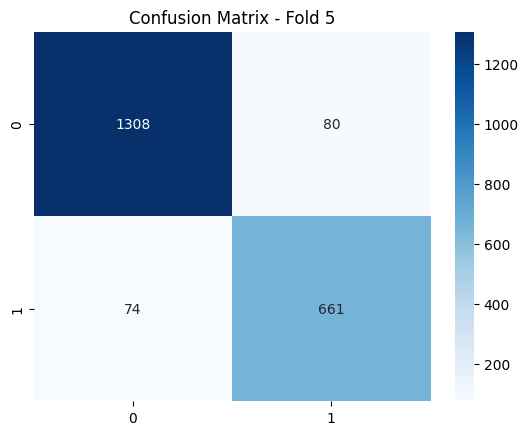

🗑️  Folder fold 5 dihapus

✅ Model TERBAIK (Fold 2, F1: 0.9331) disimpan di: /content/drive/MyDrive/Kodingan TA/indoBERT_model_tanpa_replies/best_fold_model
📄 Rekap fold → hasil_kfold_f1_tanpa_replies.csv


In [ ]:
import numpy as np, pandas as pd, torch, shutil, os, seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn, gc
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import (set_seed, BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# ========= SETUP =========
set_seed(42)
MODEL     = "indobenchmark/indobert-base-p2"
BEST_DIR  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model_tanpa_replies/best_fold_model"
TMP_ROOT  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model_tanpa_replies/tmp_folds"
os.makedirs(TMP_ROOT, exist_ok=True)

# ========= DATA ==========
df = pd.read_csv("/content/drive/MyDrive/Kodingan TA/cleaned_final_tanpa_replies.csv")
df = df[["text", "sentiment_label"]].dropna()
df["sentiment_label"] = df["sentiment_label"].astype(int)

tokenizer = BertTokenizer.from_pretrained(MODEL)

class IndoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, txt, lab, tok, max_len=128):
        self.txt, self.lab, self.tok, self.max_len = txt, lab, tok, max_len
    def __len__(self): return len(self.txt)
    def __getitem__(self, idx):
        enc = self.tok(str(self.txt[idx]), max_length=self.max_len,
                       padding="max_length", truncation=True, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.lab[idx], dtype=torch.long)
        return item

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *a, **kw):
        super().__init__(*a, **kw); self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        out  = model(**inputs); logits = out.logits
        loss = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))(logits, inputs["labels"])
        return (loss, out) if return_outputs else loss

def compute_metrics(pred):
    y_true, y_pred = pred.label_ids, pred.predictions.argmax(-1)
    return {"eval_accuracy": accuracy_score(y_true, y_pred),
            "eval_f1":       f1_score(y_true, y_pred, average="macro")}

# ========= TRAINING =========
best_f1, best_fold, best_tmp = 0., None, None
fold_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr, va) in enumerate(skf.split(df.text, df.sentiment_label), 1):
    print(f"\n===== FOLD {fold} =====")
    print("Distribusi train:", Counter(df.sentiment_label.iloc[tr]))

    tr_ds = IndoBERTDataset(df.text.iloc[tr].tolist(), df.sentiment_label.iloc[tr].tolist(), tokenizer)
    va_ds = IndoBERTDataset(df.text.iloc[va].tolist(), df.sentiment_label.iloc[va].tolist(), tokenizer)

    cw = torch.tensor(
        compute_class_weight("balanced", classes=np.array([0,1]),
                             y=df.sentiment_label.iloc[tr]), dtype=torch.float)

    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=2)
    tmp   = f"{TMP_ROOT}/fold_{fold}"

    args = TrainingArguments(
        output_dir              = tmp,
        evaluation_strategy     = "epoch",
        save_strategy           = "epoch",
        logging_strategy        = "epoch",
        save_total_limit        = 1,
        load_best_model_at_end  = True,
        metric_for_best_model   = "eval_f1",
        greater_is_better       = True,
        num_train_epochs        = 5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size  = 16,
        learning_rate           = 3e-5,
        weight_decay            = 0.01,
        fp16                    = True,
        logging_steps           = 1,          # tak dipakai karena logging_strategy="epoch"
        # disable_tqdm            = True,       # ⬅️  MATIKAN tqdm ⇒ baris tidak di-overwrite
        report_to               = "none",
      )

    trainer = WeightedTrainer(model=model, args=args,
                              train_dataset=tr_ds, eval_dataset=va_ds,
                              compute_metrics=compute_metrics,
                              callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                              class_weights=cw)

    trainer.train()                     # ← progress-bar + tabel muncul lengkap

    # —— evaluasi terakhir fold
    metrics = trainer.evaluate(); f1 = metrics["eval_f1"]; acc = metrics["eval_accuracy"]

    # Confusion matrix + report
    preds  = trainer.predict(va_ds)
    y_true = preds.label_ids; y_pred = preds.predictions.argmax(-1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negatif","Positif"]))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}'); plt.show()

    # —— pilih model terbaik
    if f1 > best_f1:
        if best_tmp and os.path.exists(best_tmp): shutil.rmtree(best_tmp)
        best_f1, best_fold, best_tmp = f1, fold, tmp
        print(f"✅ Fold {fold} TERBAIK sementara (F1 {f1:.4f})")
    else:
        shutil.rmtree(tmp); print("🗑️  Folder fold", fold, "dihapus")

    fold_results.append({"fold": fold, "f1": f1, "accuracy": acc})

# —— simpan model terbaik
if os.path.exists(BEST_DIR): shutil.rmtree(BEST_DIR)
shutil.copytree(best_tmp, BEST_DIR); tokenizer.save_pretrained(BEST_DIR)
shutil.rmtree(best_tmp)
print(f"\n✅ Model TERBAIK (Fold {best_fold}, F1: {best_f1:.4f}) disimpan di: {BEST_DIR}")

pd.DataFrame(fold_results).to_csv("/content/hasil_kfold_f1_tanpa_replies.csv", index=False)
print("📄 Rekap fold → hasil_kfold_f1_tanpa_replies.csv")


## replies


===== FOLD 1 =====
Distribusi: Counter({0: 5643, 1: 2988})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.180100,0.248479,0.915663,0.907750
2,0.116000,0.223007,0.928638,0.921661
3,0.083800,0.316963,0.911029,0.904800
4,0.029300,0.354839,0.931881,0.924829
5,0.015400,0.368436,0.925857,0.918950



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.95      0.95      1411
     Positif       0.90      0.90      0.90       747

    accuracy                           0.93      2158
   macro avg       0.92      0.93      0.92      2158
weighted avg       0.93      0.93      0.93      2158

DEBUG => val_f1: 0.9248287280485057


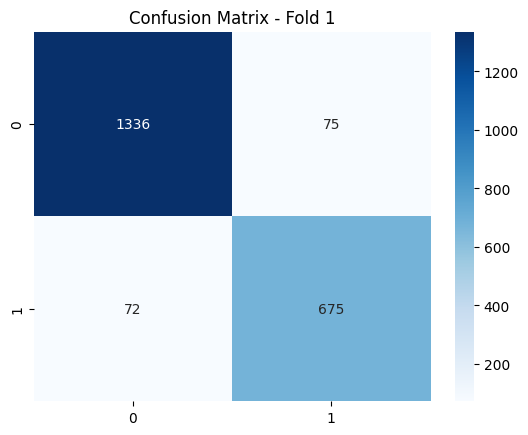

✅ Fold 1 jadi yang terbaik sejauh ini (F1: 0.9248)

===== FOLD 2 =====
Distribusi: Counter({0: 5643, 1: 2988})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.227300,0.188180,0.927711,0.921698
2,0.092500,0.224936,0.942539,0.936650
3,0.072400,0.295490,0.936515,0.929854
4,0.016200,0.342680,0.940222,0.933992



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.95      0.96      1411
     Positif       0.91      0.92      0.92       747

    accuracy                           0.94      2158
   macro avg       0.94      0.94      0.94      2158
weighted avg       0.94      0.94      0.94      2158

DEBUG => val_f1: 0.9366496212121211


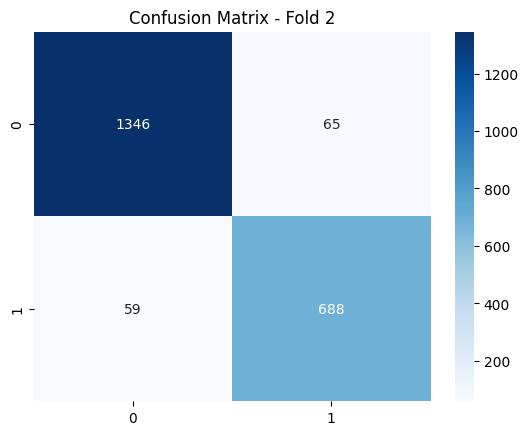

✅ Fold 2 jadi yang terbaik sejauh ini (F1: 0.9366)

===== FOLD 3 =====
Distribusi: Counter({0: 5643, 1: 2988})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.210700,0.183488,0.916589,0.910750
2,0.154900,0.208634,0.919370,0.914236
3,0.091000,0.236570,0.942076,0.934933
4,0.013200,0.250479,0.949027,0.943872
5,0.022200,0.263072,0.944856,0.939070



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.96      0.96      1411
     Positif       0.92      0.93      0.93       747

    accuracy                           0.95      2158
   macro avg       0.94      0.95      0.94      2158
weighted avg       0.95      0.95      0.95      2158

DEBUG => val_f1: 0.9438718183469024


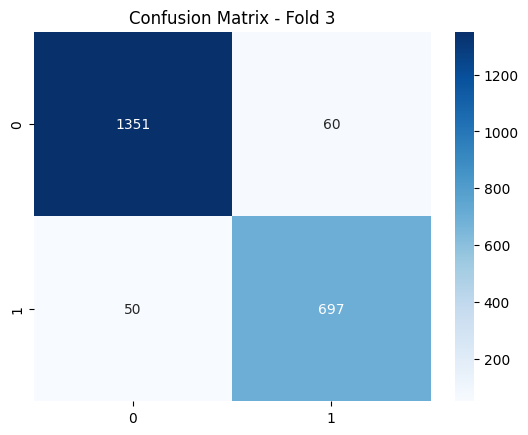

✅ Fold 3 jadi yang terbaik sejauh ini (F1: 0.9439)

===== FOLD 4 =====
Distribusi: Counter({0: 5643, 1: 2988})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.186000,0.209739,0.909639,0.903674
2,0.144500,0.227318,0.929564,0.921068
3,0.093700,0.237459,0.926784,0.921293
4,0.017300,0.294318,0.943466,0.937395
5,0.028200,0.301001,0.939759,0.933789



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.96      0.96      1411
     Positif       0.92      0.91      0.92       747

    accuracy                           0.94      2158
   macro avg       0.94      0.94      0.94      2158
weighted avg       0.94      0.94      0.94      2158

DEBUG => val_f1: 0.9373954315662318


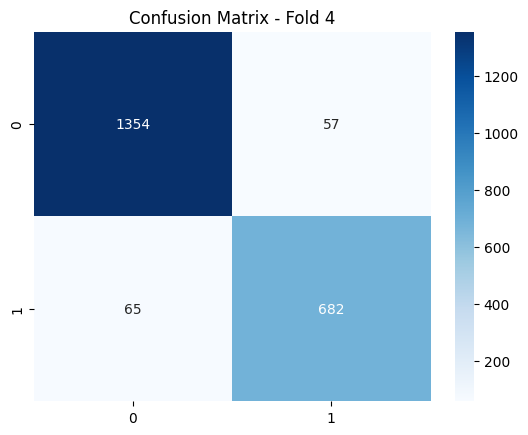

🗑️  Folder fold 4 dihapus

===== FOLD 5 =====
Distribusi: Counter({0: 5644, 1: 2988})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.212800,0.208168,0.932313,0.925298
2,0.117100,0.226002,0.936486,0.929057
3,0.060300,0.253319,0.942513,0.936752
4,0.013500,0.275930,0.944367,0.938716
5,0.005900,0.300576,0.942976,0.937125



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.95      0.96      1410
     Positif       0.92      0.93      0.92       747

    accuracy                           0.94      2157
   macro avg       0.94      0.94      0.94      2157
weighted avg       0.94      0.94      0.94      2157

DEBUG => val_f1: 0.9387161357166263


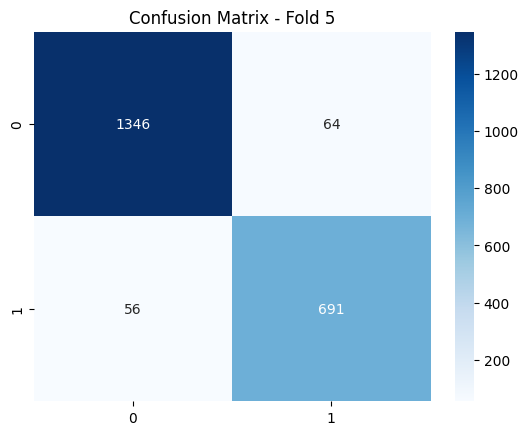

🗑️  Folder fold 5 dihapus

✅ Model fold 3 disalin ke: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model

✅ Model TERBAIK (Fold 3, F1: 0.9439) disimpan di: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model


In [ ]:
import numpy as np, pandas as pd, torch, shutil, os, gc, seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_recall_fscore_support)
from transformers import (set_seed, BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# ============ SETUP ============
set_seed(42)
MODEL      = "indobenchmark/indobert-base-p2"

BEST_DIR  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model"
TMP_ROOT  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/tmp_folds"
os.makedirs(TMP_ROOT, exist_ok=True)

# ============ DATA  ============
df = pd.read_csv("/content/drive/MyDrive/Kodingan TA/final_no_stop_removed_cleaned_sama_cleaned.csv")
df = df[["text", "sentiment_label"]].dropna()
df["sentiment_label"] = df["sentiment_label"].astype(int)

tokenizer = BertTokenizer.from_pretrained(MODEL)

class IndoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, txt, lab, tok, max_len=128):
        self.txt, self.lab, self.tok, self.max_len = txt, lab, tok, max_len
    def __len__(self): return len(self.txt)
    def __getitem__(self, idx):
        enc = self.tok(str(self.txt[idx]), max_length=self.max_len,
                       padding="max_length", truncation=True, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.lab[idx], dtype=torch.long)
        return item

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *a, **kw):
        super().__init__(*a, **kw); self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs["labels"]
        output  = model(**inputs); logits = output.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss    = loss_fn(logits, labels)
        return (loss, output) if return_outputs else loss

def compute_metrics(pred):
    y_true, y_pred = pred.label_ids, pred.predictions.argmax(-1)
    return {"eval_accuracy": accuracy_score(y_true, y_pred),
            "eval_f1":       f1_score(y_true, y_pred, average="macro")}

# ============ TRAIN ============
best_f1, best_fold, best_tmp = 0., None, None
fold_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr, va) in enumerate(skf.split(df.text, df.sentiment_label), 1):
    print(f"\n===== FOLD {fold} =====")
    tr_ds = IndoBERTDataset(df.text.iloc[tr].tolist(),  df.sentiment_label.iloc[tr].tolist(),  tokenizer)
    va_ds = IndoBERTDataset(df.text.iloc[va].tolist(),  df.sentiment_label.iloc[va].tolist(),  tokenizer)
    print("Distribusi:", Counter(df.sentiment_label.iloc[tr]))

    cw = torch.tensor(
        compute_class_weight(class_weight="balanced",
                             classes=np.array([0, 1]),
                             y=df.sentiment_label.iloc[tr]),
        dtype=torch.float)
    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=2)
    tmp = f"{TMP_ROOT}/fold_{fold}"

    args = TrainingArguments(
        output_dir              = tmp,
        evaluation_strategy     = "epoch",
        save_strategy           = "epoch",
        save_total_limit        = 1,
        load_best_model_at_end  = True,
        metric_for_best_model   = "eval_f1",
        greater_is_better       = True,
        num_train_epochs        = 5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size  = 16,
        learning_rate           = 3e-5,
        weight_decay            = 0.01,
        fp16                    = True,
        logging_steps           = 20,
        gradient_accumulation_steps = 2,
        report_to               = "none",
    )

    trainer = WeightedTrainer(model=model, args=args, train_dataset=tr_ds, eval_dataset=va_ds,
                              compute_metrics=compute_metrics,
                              callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                              class_weights=cw)

    trainer.train()
    metrics = trainer.evaluate(); f1 = metrics["eval_f1"]

    # ---------- pretty classification report ----------
    y_pred = trainer.predict(va_ds).predictions.argmax(-1)
    y_true = va_ds.lab
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negatif","Positif"]))
    print(f"DEBUG => val_f1: {f1}")

    # confusion matrix
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}'); plt.show()

    if f1 > best_f1:
        if best_tmp and os.path.exists(best_tmp): shutil.rmtree(best_tmp)
        best_f1, best_fold, best_tmp = f1, fold, tmp
        print(f"✅ Fold {fold} jadi yang terbaik sejauh ini (F1: {f1:.4f})")
    else:
        shutil.rmtree(tmp); print(f"🗑️  Folder fold {fold} dihapus")

    fold_results.append({"fold":fold,"f1":f1,"accuracy":metrics["eval_accuracy"]})

# -------- save best -----------
if os.path.exists(BEST_DIR): shutil.rmtree(BEST_DIR)
shutil.copytree(best_tmp, BEST_DIR); tokenizer.save_pretrained(BEST_DIR)
shutil.rmtree(best_tmp)
print(f"\n✅ Model fold {best_fold} disalin ke: {BEST_DIR}")

print(f"\n✅ Model TERBAIK (Fold {best_fold}, F1: {best_f1:.4f}) disimpan di: {BEST_DIR}")

pd.DataFrame(fold_results).to_csv("/content/hasil_kfold_f1.csv", index=False)



# SPLITING DATA SECTION

## 70 Trainng dan 30 Testing

### Menggunakan Class Weight

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]


===== FOLD 1 =====
Distribusi: Counter({0: 4938, 1: 2614})


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.231600,0.201258,0.908866,0.903754
2,0.090100,0.172324,0.940377,0.935137
3,0.065000,0.218535,0.944393,0.938769
4,0.033200,0.245474,0.950263,0.945061
5,0.015300,0.271070,0.947791,0.942283



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.96      0.96      2116
     Positif       0.93      0.93      0.93      1121

    accuracy                           0.95      3237
   macro avg       0.95      0.94      0.95      3237
weighted avg       0.95      0.95      0.95      3237

DEBUG => val_f1: 0.9450612909152951


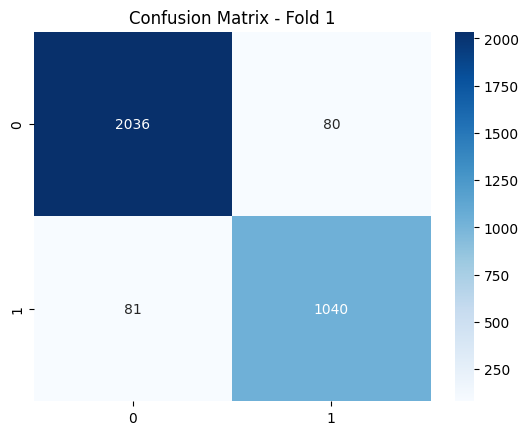

✅ Fold 1 jadi yang terbaik sejauh ini (F1: 0.9451)

===== FOLD 2 =====
Distribusi: Counter({0: 4938, 1: 2614})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.223800,0.185548,0.924004,0.917683
2,0.116400,0.190402,0.934507,0.928377
3,0.063300,0.287737,0.938523,0.931538
4,0.021400,0.303848,0.937905,0.932500
5,0.027400,0.331517,0.940068,0.934195



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.95      0.95      2116
     Positif       0.90      0.93      0.91      1121

    accuracy                           0.94      3237
   macro avg       0.93      0.94      0.93      3237
weighted avg       0.94      0.94      0.94      3237

DEBUG => val_f1: 0.9341954589084447


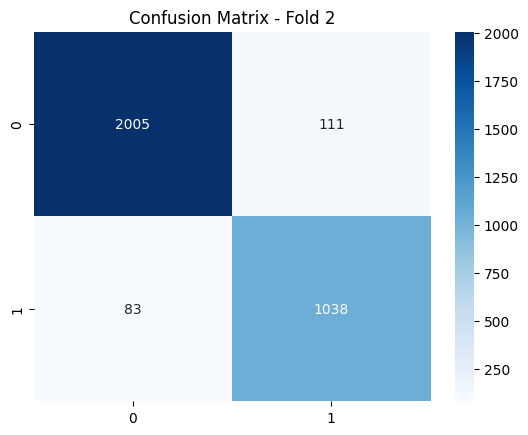

🗑️  Folder fold 2 dihapus

===== FOLD 3 =====
Distribusi: Counter({0: 4938, 1: 2614})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.235200,0.192226,0.923386,0.917465
2,0.106400,0.222656,0.928947,0.922864
3,0.035400,0.293030,0.934816,0.928385
4,0.031000,0.336640,0.930491,0.924583
5,0.003400,0.370100,0.939141,0.932917



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.95      0.95      2116
     Positif       0.91      0.92      0.91      1121

    accuracy                           0.94      3237
   macro avg       0.93      0.93      0.93      3237
weighted avg       0.94      0.94      0.94      3237

DEBUG => val_f1: 0.9329170196464897


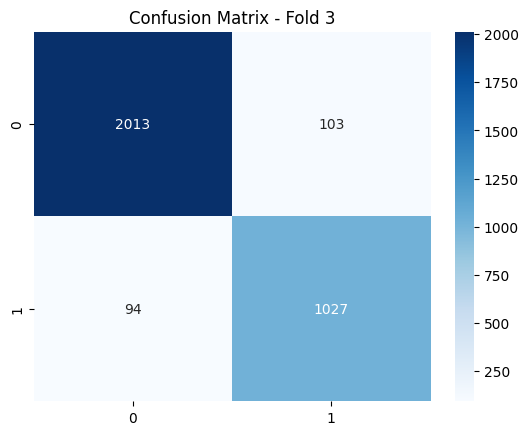

🗑️  Folder fold 3 dihapus

===== FOLD 4 =====
Distribusi: Counter({0: 4938, 1: 2614})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.259100,0.183130,0.927093,0.920911
2,0.111700,0.204522,0.936670,0.930135
3,0.068000,0.319698,0.933889,0.926991
4,0.013600,0.361776,0.936052,0.929453



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.95      0.95      2116
     Positif       0.91      0.91      0.91      1121

    accuracy                           0.94      3237
   macro avg       0.93      0.93      0.93      3237
weighted avg       0.94      0.94      0.94      3237

DEBUG => val_f1: 0.9301347463363343


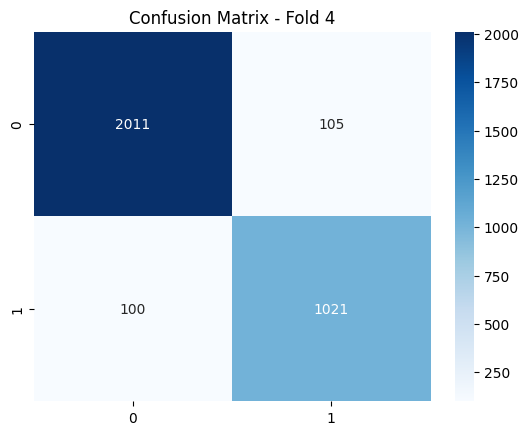

🗑️  Folder fold 4 dihapus

===== FOLD 5 =====
Distribusi: Counter({0: 4938, 1: 2614})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.234400,0.208110,0.905468,0.899999
2,0.132400,0.164672,0.941922,0.936782
3,0.074900,0.219289,0.942848,0.937682
4,0.013600,0.268280,0.945011,0.939093
5,0.023600,0.286215,0.947173,0.941698



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.96      0.96      2116
     Positif       0.92      0.93      0.92      1121

    accuracy                           0.95      3237
   macro avg       0.94      0.94      0.94      3237
weighted avg       0.95      0.95      0.95      3237

DEBUG => val_f1: 0.941697821964261


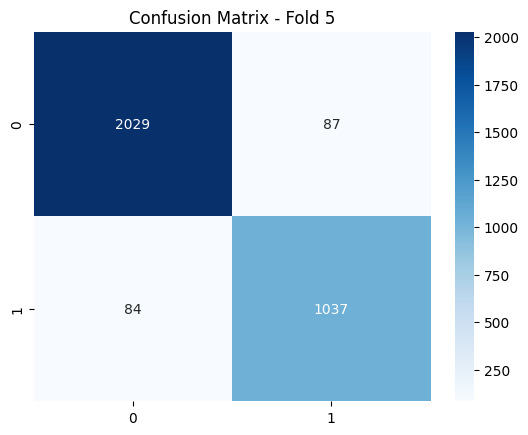

🗑️  Folder fold 5 dihapus

✅ Model fold 1 disalin ke: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_70_30_CW

✅ Model TERBAIK (Fold 1, F1: 0.9451) disimpan di: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_70_30_CW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np, pandas as pd, torch, shutil, os, gc, seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_recall_fscore_support)
from transformers import (set_seed, BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# ============ SETUP ============
set_seed(42)
MODEL      = "indobenchmark/indobert-base-p2"

BEST_DIR  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_70_30_CW"
TMP_ROOT  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/tmp_folds_70_30_CW"
os.makedirs(TMP_ROOT, exist_ok=True)

# ============ DATA  ============
df = pd.read_csv("/content/drive/MyDrive/Kodingan TA/final_no_stop_removed_cleaned_sama_cleaned.csv")
df = df[["text", "sentiment_label"]].dropna()
df["sentiment_label"] = df["sentiment_label"].astype(int)

tokenizer = BertTokenizer.from_pretrained(MODEL)

class IndoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, txt, lab, tok, max_len=128):
        self.txt, self.lab, self.tok, self.max_len = txt, lab, tok, max_len
    def __len__(self): return len(self.txt)
    def __getitem__(self, idx):
        enc = self.tok(str(self.txt[idx]), max_length=self.max_len,
                       padding="max_length", truncation=True, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.lab[idx], dtype=torch.long)
        return item

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *a, **kw):
        super().__init__(*a, **kw); self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs["labels"]
        output  = model(**inputs); logits = output.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss    = loss_fn(logits, labels)
        return (loss, output) if return_outputs else loss

def compute_metrics(pred):
    y_true, y_pred = pred.label_ids, pred.predictions.argmax(-1)
    return {"eval_accuracy": accuracy_score(y_true, y_pred),
            "eval_f1":       f1_score(y_true, y_pred, average="macro")}

# ============ TRAIN ============
best_f1, best_fold, best_tmp = 0., None, None
fold_results = []
sss = StratifiedShuffleSplit(
    n_splits=5,          # “5 fold”
    test_size=0.30,      # 30 % untuk validasi
    random_state=42,
)

for fold, (tr, va) in enumerate(sss.split(df.text, df.sentiment_label), 1):
    print(f"\n===== FOLD {fold} =====")
    tr_ds = IndoBERTDataset(df.text.iloc[tr].tolist(),  df.sentiment_label.iloc[tr].tolist(),  tokenizer)
    va_ds = IndoBERTDataset(df.text.iloc[va].tolist(),  df.sentiment_label.iloc[va].tolist(),  tokenizer)
    print("Distribusi:", Counter(df.sentiment_label.iloc[tr]))

    cw = torch.tensor(
        compute_class_weight(class_weight="balanced",
                             classes=np.array([0, 1]),
                             y=df.sentiment_label.iloc[tr]),
        dtype=torch.float)
    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=2)
    tmp = f"{TMP_ROOT}/fold_{fold}"

    args = TrainingArguments(
        output_dir              = tmp,
        evaluation_strategy     = "epoch",
        save_strategy           = "epoch",
        save_total_limit        = 1,
        load_best_model_at_end  = True,
        metric_for_best_model   = "eval_f1",
        greater_is_better       = True,
        num_train_epochs        = 5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size  = 16,
        learning_rate           = 3e-5,
        weight_decay            = 0.01,
        fp16                    = True,
        logging_steps           = 20,
        gradient_accumulation_steps = 2,
        report_to               = "none",
    )

    trainer = WeightedTrainer(model=model, args=args, train_dataset=tr_ds, eval_dataset=va_ds,
                              compute_metrics=compute_metrics,
                              callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                              class_weights=cw)

    trainer.train()
    metrics = trainer.evaluate(); f1 = metrics["eval_f1"]

    # ---------- pretty classification report ----------
    y_pred = trainer.predict(va_ds).predictions.argmax(-1)
    y_true = va_ds.lab
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negatif","Positif"]))
    print(f"DEBUG => val_f1: {f1}")

    # confusion matrix
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}'); plt.show()

    if f1 > best_f1:
        if best_tmp and os.path.exists(best_tmp): shutil.rmtree(best_tmp)
        best_f1, best_fold, best_tmp = f1, fold, tmp
        print(f"✅ Fold {fold} jadi yang terbaik sejauh ini (F1: {f1:.4f})")
    else:
        shutil.rmtree(tmp); print(f"🗑️  Folder fold {fold} dihapus")

    fold_results.append({"fold":fold,"f1":f1,"accuracy":metrics["eval_accuracy"]})

# -------- save best -----------
if os.path.exists(BEST_DIR): shutil.rmtree(BEST_DIR)
shutil.copytree(best_tmp, BEST_DIR); tokenizer.save_pretrained(BEST_DIR)
shutil.rmtree(best_tmp)
print(f"\n✅ Model fold {best_fold} disalin ke: {BEST_DIR}")

print(f"\n✅ Model TERBAIK (Fold {best_fold}, F1: {best_f1:.4f}) disimpan di: {BEST_DIR}")

pd.DataFrame(fold_results).to_csv("/content/hasil_kfold_f1_70_30_cw.csv", index=False)
from google.colab import files
files.download("/content/hasil_kfold_f1_70_30_cw.csv")

### tanpa imbalanced data

## 60 Trainng dan 40 Testing

### Imbalanced data handling


===== FOLD 1 =====
Distribusi: Counter({0: 4232, 1: 2241})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.218600,0.177527,0.928869,0.922813
2,0.075600,0.232554,0.938369,0.932506
4,0.039400,0.279647,0.940918,0.934563



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.96      0.96      2822
     Positif       0.92      0.92      0.92      1494

    accuracy                           0.94      4316
   macro avg       0.94      0.94      0.94      4316
weighted avg       0.94      0.94      0.94      4316

DEBUG => val_f1: 0.9370620963888846


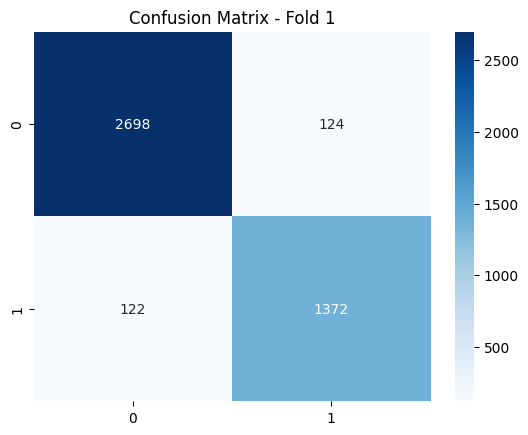

✅ Fold 1 jadi yang terbaik sejauh ini (F1: 0.9371)

===== FOLD 2 =====
Distribusi: Counter({0: 4232, 1: 2241})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.204000,0.319231,0.854263,0.849511
2,0.042500,0.279521,0.932345,0.926020
4,0.008100,0.336435,0.933040,0.926682



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.94      0.95      2822
     Positif       0.89      0.92      0.91      1494

    accuracy                           0.93      4316
   macro avg       0.92      0.93      0.93      4316
weighted avg       0.93      0.93      0.93      4316

DEBUG => val_f1: 0.9266815440371047


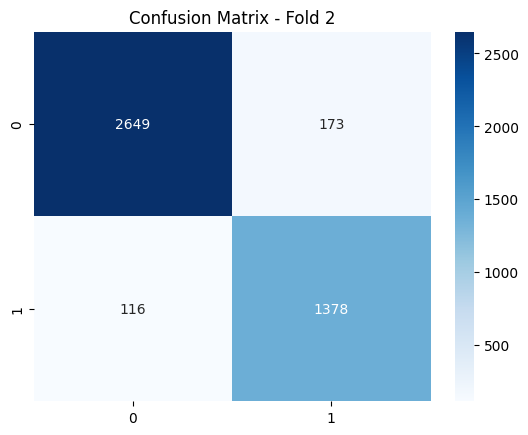

🗑️  Folder fold 2 dihapus

===== FOLD 3 =====
Distribusi: Counter({0: 4232, 1: 2241})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.188500,0.235533,0.893883,0.888065
2,0.051600,0.292243,0.931418,0.924804
4,0.009900,0.379475,0.937442,0.930965



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.95      0.95      2822
     Positif       0.91      0.91      0.91      1494

    accuracy                           0.94      4316
   macro avg       0.93      0.93      0.93      4316
weighted avg       0.94      0.94      0.94      4316

DEBUG => val_f1: 0.930965158411893


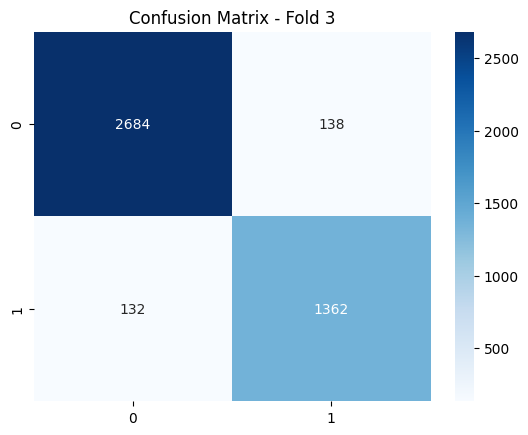

🗑️  Folder fold 3 dihapus

===== FOLD 4 =====
Distribusi: Counter({0: 4232, 1: 2241})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.202000,0.188453,0.926784,0.920220
2,0.050000,0.325312,0.938601,0.931206
4,0.003900,0.337706,0.941381,0.935013



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.96      0.96      2822
     Positif       0.92      0.91      0.91      1494

    accuracy                           0.94      4316
   macro avg       0.94      0.93      0.94      4316
weighted avg       0.94      0.94      0.94      4316

DEBUG => val_f1: 0.9350133654473058


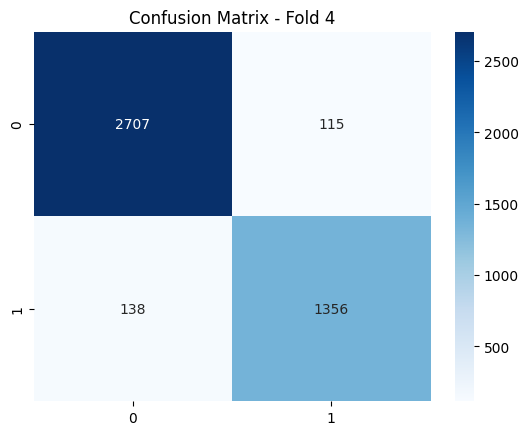

🗑️  Folder fold 4 dihapus

===== FOLD 5 =====
Distribusi: Counter({0: 4232, 1: 2241})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.191300,0.189804,0.920760,0.915039
2,0.063300,0.250823,0.937210,0.931806
4,0.012600,0.243345,0.946942,0.941834



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.97      0.95      0.96      2822
     Positif       0.91      0.94      0.92      1494

    accuracy                           0.95      4316
   macro avg       0.94      0.95      0.94      4316
weighted avg       0.95      0.95      0.95      4316

DEBUG => val_f1: 0.9418336200856696


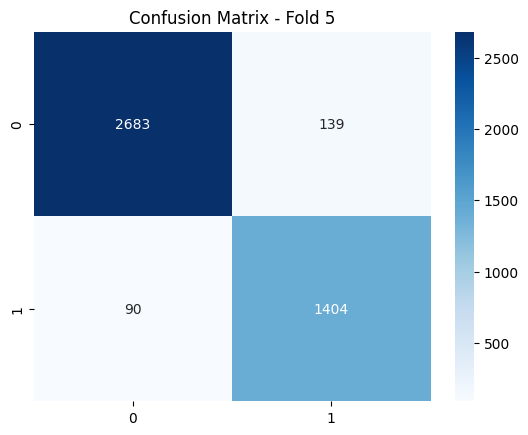

✅ Fold 5 jadi yang terbaik sejauh ini (F1: 0.9418)

✅ Model fold 5 disalin ke: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_60_40_CW

✅ Model TERBAIK (Fold 5, F1: 0.9418) disimpan di: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_60_40_CW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np, pandas as pd, torch, shutil, os, gc, seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_recall_fscore_support)
from transformers import (set_seed, BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# ============ SETUP ============
set_seed(42)
MODEL      = "indobenchmark/indobert-base-p2"

BEST_DIR  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_60_40_CW"
TMP_ROOT  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/tmp_folds_60_40_CW"
os.makedirs(TMP_ROOT, exist_ok=True)

# ============ DATA  ============
df = pd.read_csv("/content/drive/MyDrive/Kodingan TA/final_no_stop_removed_cleaned_sama_cleaned.csv")
df = df[["text", "sentiment_label"]].dropna()
df["sentiment_label"] = df["sentiment_label"].astype(int)

tokenizer = BertTokenizer.from_pretrained(MODEL)

class IndoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, txt, lab, tok, max_len=128):
        self.txt, self.lab, self.tok, self.max_len = txt, lab, tok, max_len
    def __len__(self): return len(self.txt)
    def __getitem__(self, idx):
        enc = self.tok(str(self.txt[idx]), max_length=self.max_len,
                       padding="max_length", truncation=True, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.lab[idx], dtype=torch.long)
        return item

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *a, **kw):
        super().__init__(*a, **kw); self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs["labels"]
        output  = model(**inputs); logits = output.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss    = loss_fn(logits, labels)
        return (loss, output) if return_outputs else loss

def compute_metrics(pred):
    y_true, y_pred = pred.label_ids, pred.predictions.argmax(-1)
    return {"eval_accuracy": accuracy_score(y_true, y_pred),
            "eval_f1":       f1_score(y_true, y_pred, average="macro")}

# ============ TRAIN ============
best_f1, best_fold, best_tmp = 0., None, None
fold_results = []
sss = StratifiedShuffleSplit(
    n_splits=5,          # “5 fold”
    test_size=0.40,      # 40 % untuk validasi
    random_state=42,
)

for fold, (tr, va) in enumerate(sss.split(df.text, df.sentiment_label), 1):
    print(f"\n===== FOLD {fold} =====")
    tr_ds = IndoBERTDataset(df.text.iloc[tr].tolist(),  df.sentiment_label.iloc[tr].tolist(),  tokenizer)
    va_ds = IndoBERTDataset(df.text.iloc[va].tolist(),  df.sentiment_label.iloc[va].tolist(),  tokenizer)
    print("Distribusi:", Counter(df.sentiment_label.iloc[tr]))

    cw = torch.tensor(
        compute_class_weight(class_weight="balanced",
                             classes=np.array([0, 1]),
                             y=df.sentiment_label.iloc[tr]),
        dtype=torch.float)
    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=2)
    tmp = f"{TMP_ROOT}/fold_{fold}"

    args = TrainingArguments(
        output_dir              = tmp,
        evaluation_strategy     = "epoch",
        save_strategy           = "epoch",
        save_total_limit        = 1,
        load_best_model_at_end  = True,
        metric_for_best_model   = "eval_f1",
        greater_is_better       = True,
        num_train_epochs        = 5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size  = 16,
        learning_rate           = 3e-5,
        weight_decay            = 0.01,
        fp16                    = True,
        logging_steps           = 20,
        gradient_accumulation_steps = 2,
        report_to               = "none",
    )

    trainer = WeightedTrainer(model=model, args=args, train_dataset=tr_ds, eval_dataset=va_ds,
                              compute_metrics=compute_metrics,
                              callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                              class_weights=cw)

    trainer.train()
    metrics = trainer.evaluate(); f1 = metrics["eval_f1"]

    # ---------- pretty classification report ----------
    y_pred = trainer.predict(va_ds).predictions.argmax(-1)
    y_true = va_ds.lab
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negatif","Positif"]))
    print(f"DEBUG => val_f1: {f1}")

    # confusion matrix
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}'); plt.show()

    if f1 > best_f1:
        if best_tmp and os.path.exists(best_tmp): shutil.rmtree(best_tmp)
        best_f1, best_fold, best_tmp = f1, fold, tmp
        print(f"✅ Fold {fold} jadi yang terbaik sejauh ini (F1: {f1:.4f})")
    else:
        shutil.rmtree(tmp); print(f"🗑️  Folder fold {fold} dihapus")

    fold_results.append({"fold":fold,"f1":f1,"accuracy":metrics["eval_accuracy"]})

# -------- save best -----------
if os.path.exists(BEST_DIR): shutil.rmtree(BEST_DIR)
shutil.copytree(best_tmp, BEST_DIR); tokenizer.save_pretrained(BEST_DIR)
shutil.rmtree(best_tmp)
print(f"\n✅ Model fold {best_fold} disalin ke: {BEST_DIR}")

print(f"\n✅ Model TERBAIK (Fold {best_fold}, F1: {best_f1:.4f}) disimpan di: {BEST_DIR}")

pd.DataFrame(fold_results).to_csv("/content/hasil_kfold_f1_60_40_cw.csv", index=False)
from google.colab import files
files.download("/content/hasil_kfold_f1_60_40_cw.csv")

## 90 Trainng dan 10 Testing

### Imbalanced data handling


===== FOLD 1 =====
Distribusi: Counter({0: 6349, 1: 3361})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.243500,0.145487,0.952734,0.947455
2,0.076400,0.215810,0.939759,0.934490
4,0.055100,0.296367,0.946247,0.940046



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.96      0.96       705
     Positif       0.93      0.93      0.93       374

    accuracy                           0.95      1079
   macro avg       0.95      0.95      0.95      1079
weighted avg       0.95      0.95      0.95      1079

DEBUG => val_f1: 0.9478566643388251


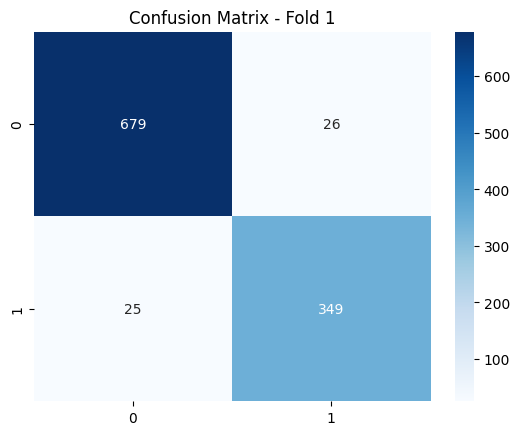

✅ Fold 1 jadi yang terbaik sejauh ini (F1: 0.9479)

===== FOLD 2 =====
Distribusi: Counter({0: 6349, 1: 3361})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.162100,0.234770,0.914736,0.905398
2,0.067100,0.342205,0.934198,0.926657
4,0.019800,0.364677,0.939759,0.933290


Could not locate the best model at /content/drive/MyDrive/Kodingan TA/indoBERT_model/tmp_folds_90_10_CW/fold_2/checkpoint-1515/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.95      0.96      0.95       705
     Positif       0.92      0.91      0.91       374

    accuracy                           0.94      1079
   macro avg       0.93      0.93      0.93      1079
weighted avg       0.94      0.94      0.94      1079

DEBUG => val_f1: 0.9332902139640176


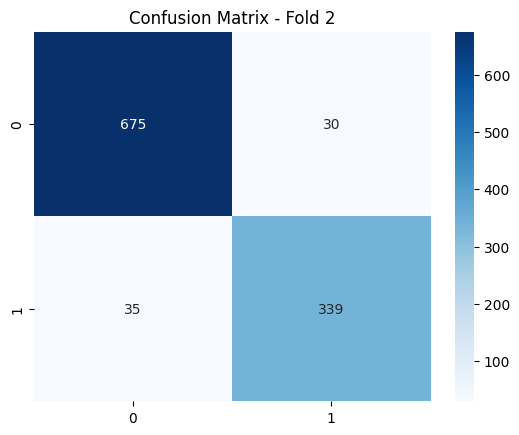

🗑️  Folder fold 2 dihapus

===== FOLD 3 =====
Distribusi: Counter({0: 6349, 1: 3361})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.201200,0.165540,0.945320,0.940047
2,0.046800,0.296992,0.946247,0.939804



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.97      0.95      0.96       705
     Positif       0.91      0.94      0.92       374

    accuracy                           0.95      1079
   macro avg       0.94      0.94      0.94      1079
weighted avg       0.95      0.95      0.95      1079

DEBUG => val_f1: 0.9400465794784718


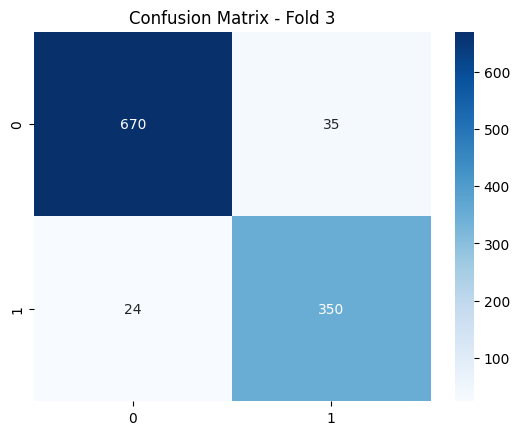

🗑️  Folder fold 3 dihapus

===== FOLD 4 =====
Distribusi: Counter({0: 6349, 1: 3361})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.186800,0.210234,0.925857,0.917194
2,0.094800,0.264587,0.939759,0.933870
4,0.030500,0.363575,0.942539,0.936490



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.96      0.96       705
     Positif       0.92      0.93      0.92       374

    accuracy                           0.95      1079
   macro avg       0.94      0.94      0.94      1079
weighted avg       0.95      0.95      0.95      1079

DEBUG => val_f1: 0.9397524456848343


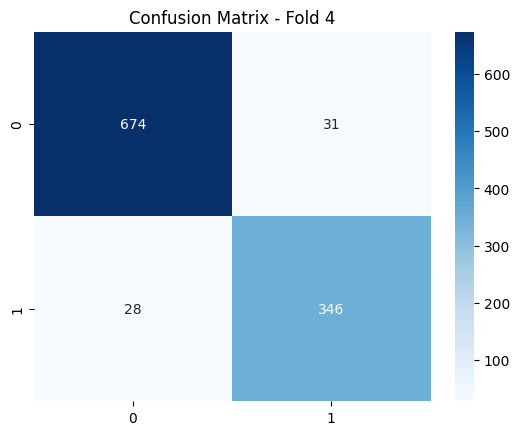

🗑️  Folder fold 4 dihapus

===== FOLD 5 =====
Distribusi: Counter({0: 6349, 1: 3361})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.209200,0.156227,0.943466,0.937939
2,0.056500,0.198638,0.954588,0.949839
4,0.015300,0.232080,0.957368,0.953341


Could not locate the best model at /content/drive/MyDrive/Kodingan TA/indoBERT_model/tmp_folds_90_10_CW/fold_5/checkpoint-1515/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.



Classification Report:
              precision    recall  f1-score   support

     Negatif       0.98      0.96      0.97       705
     Positif       0.92      0.96      0.94       374

    accuracy                           0.96      1079
   macro avg       0.95      0.96      0.95      1079
weighted avg       0.96      0.96      0.96      1079

DEBUG => val_f1: 0.9533406282667388


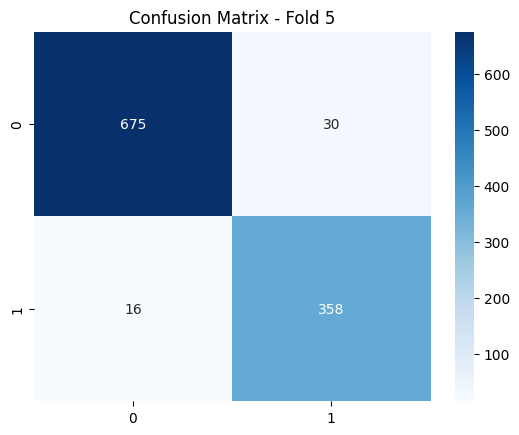

✅ Fold 5 jadi yang terbaik sejauh ini (F1: 0.9533)

✅ Model fold 5 disalin ke: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_90_10_CW

✅ Model TERBAIK (Fold 5, F1: 0.9533) disimpan di: /content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_90_10_CW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np, pandas as pd, torch, shutil, os, gc, seaborn as sns, matplotlib.pyplot as plt
import torch.nn as nn
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_recall_fscore_support)
from transformers import (set_seed, BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# ============ SETUP ============
set_seed(42)
MODEL      = "indobenchmark/indobert-base-p2"

BEST_DIR  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/best_fold_model_90_10_CW"
TMP_ROOT  = "/content/drive/MyDrive/Kodingan TA/indoBERT_model/tmp_folds_90_10_CW"
os.makedirs(TMP_ROOT, exist_ok=True)

# ============ DATA  ============
df = pd.read_csv("/content/drive/MyDrive/Kodingan TA/final_no_stop_removed_cleaned_sama_cleaned.csv")
df = df[["text", "sentiment_label"]].dropna()
df["sentiment_label"] = df["sentiment_label"].astype(int)

tokenizer = BertTokenizer.from_pretrained(MODEL)

class IndoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, txt, lab, tok, max_len=128):
        self.txt, self.lab, self.tok, self.max_len = txt, lab, tok, max_len
    def __len__(self): return len(self.txt)
    def __getitem__(self, idx):
        enc = self.tok(str(self.txt[idx]), max_length=self.max_len,
                       padding="max_length", truncation=True, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.lab[idx], dtype=torch.long)
        return item

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *a, **kw):
        super().__init__(*a, **kw); self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs["labels"]
        output  = model(**inputs); logits = output.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss    = loss_fn(logits, labels)
        return (loss, output) if return_outputs else loss

def compute_metrics(pred):
    y_true, y_pred = pred.label_ids, pred.predictions.argmax(-1)
    return {"eval_accuracy": accuracy_score(y_true, y_pred),
            "eval_f1":       f1_score(y_true, y_pred, average="macro")}

# ============ TRAIN ============
best_f1, best_fold, best_tmp = 0., None, None
fold_results = []
sss = StratifiedShuffleSplit(
    n_splits=5,          # “5 fold”
    test_size=0.10,      # 10 % untuk validasi
    random_state=42,
)

for fold, (tr, va) in enumerate(sss.split(df.text, df.sentiment_label), 1):
    print(f"\n===== FOLD {fold} =====")
    tr_ds = IndoBERTDataset(df.text.iloc[tr].tolist(),  df.sentiment_label.iloc[tr].tolist(),  tokenizer)
    va_ds = IndoBERTDataset(df.text.iloc[va].tolist(),  df.sentiment_label.iloc[va].tolist(),  tokenizer)
    print("Distribusi:", Counter(df.sentiment_label.iloc[tr]))

    cw = torch.tensor(
        compute_class_weight(class_weight="balanced",
                             classes=np.array([0, 1]),
                             y=df.sentiment_label.iloc[tr]),
        dtype=torch.float)
    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=2)
    tmp = f"{TMP_ROOT}/fold_{fold}"

    args = TrainingArguments(
        output_dir              = tmp,
        evaluation_strategy     = "epoch",
        save_strategy           = "epoch",
        save_total_limit        = 1,
        load_best_model_at_end  = True,
        metric_for_best_model   = "eval_f1",
        greater_is_better       = True,
        num_train_epochs        = 5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size  = 16,
        learning_rate           = 3e-5,
        weight_decay            = 0.01,
        fp16                    = True,
        logging_steps           = 20,
        gradient_accumulation_steps = 2,
        report_to               = "none",
    )

    trainer = WeightedTrainer(model=model, args=args, train_dataset=tr_ds, eval_dataset=va_ds,
                              compute_metrics=compute_metrics,
                              callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                              class_weights=cw)

    trainer.train()
    metrics = trainer.evaluate(); f1 = metrics["eval_f1"]

    # ---------- pretty classification report ----------
    y_pred = trainer.predict(va_ds).predictions.argmax(-1)
    y_true = va_ds.lab
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negatif","Positif"]))
    print(f"DEBUG => val_f1: {f1}")

    # confusion matrix
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}'); plt.show()

    if f1 > best_f1:
        if best_tmp and os.path.exists(best_tmp): shutil.rmtree(best_tmp)
        best_f1, best_fold, best_tmp = f1, fold, tmp
        print(f"✅ Fold {fold} jadi yang terbaik sejauh ini (F1: {f1:.4f})")
    else:
        shutil.rmtree(tmp); print(f"🗑️  Folder fold {fold} dihapus")

    fold_results.append({"fold":fold,"f1":f1,"accuracy":metrics["eval_accuracy"]})

# -------- save best -----------
if os.path.exists(BEST_DIR): shutil.rmtree(BEST_DIR)
shutil.copytree(best_tmp, BEST_DIR); tokenizer.save_pretrained(BEST_DIR)
shutil.rmtree(best_tmp)
print(f"\n✅ Model fold {best_fold} disalin ke: {BEST_DIR}")

print(f"\n✅ Model TERBAIK (Fold {best_fold}, F1: {best_f1:.4f}) disimpan di: {BEST_DIR}")

pd.DataFrame(fold_results).to_csv("/content/hasil_kfold_f1_90_10_cw.csv", index=False)
from google.colab import files
files.download("/content/hasil_kfold_f1_90_10_cw.csv")